In [1]:
import sys
import os
import numpy as np
from tsne import bh_sne
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

%matplotlib inline
from scipy.misc import imresize

sys.path.append('..')
from data import load_data
np.random.seed(247) # for reproducibility

In [2]:
# load the expression matrix
datapath='/home/peter/Data/zdata.matrix.txt'
df = pd.read_table(datapath, delimiter='\t')
df.head()

zf1_p7_S31_umi  zf2_dis_S1238_umi  zf1_p5_S91_umi  zf2_dis_S322_umi  \
A2ML                0.0                0.0             0.0          2.585148   
AAAS                0.0                0.0             0.0          0.000000   
AACS                0.0                0.0             0.0          0.000000   
AADACL4             0.0                0.0             0.0          0.000000   
AAGAB               0.0                0.0             0.0         23.266335   

         zf2_dis_S1179_umi  zf1_p6_S44_umi  zf2_dis_S1228_umi  zf1_p5_S61_umi  \
A2ML              0.000000             0.0                0.0        0.000000   
AAAS             13.500014             0.0                0.0       30.658931   
AACS              0.000000             0.0                0.0        0.000000   
AADACL4           0.000000             0.0                0.0        0.000000   
AAGAB            13.500014             0.0                0.0        0.000000   

         zf1_p6_S56_umi  zf1_p5_S66_umi        ...          zf3_dis_S1592_umi  \
A2ML           0.000000             0.0        ...                        0.0   
AAAS           8.421171             0.0        ...                        0.0   
AACS           0.000000             0.0        ...                        0.0   
AADACL4        0.000000             0.0        ...                        0.0   
AAGAB          8.421171             0.0        ...                        0.0   

         zf3_dis_S1450_umi  zf3_dis_S1762_umi  zf3_dis_S1646_umi  \
A2ML              0.000000                0.0           0.000000   
AAAS              0.000000                0.0           0.000000   
AACS              0.000000                0.0           0.000000   
AADACL4           0.000000                0.0           0.000000   
AAGAB            32.467532                0.0          22.080417   

         zf3_dis_S1503_umi  zf3_dis_S1665_umi  zf3_dis_S1636_umi  \
A2ML              0.000000           0.000000                0.0   
AAAS              0.000000          21.914206                0.0   
AACS              0.000000           0.000000                0.0   
AADACL4           0.000000           0.000000                0.0   
AAGAB             4.818232           0.000000                0.0   

         zf3_dis_S1672_umi  zf3_dis_S354_umi  zf3_dis_S1569_umi  
A2ML              0.000000               0.0           0.000000  
AAAS             24.244187               0.0           0.000000  
AACS              0.000000               0.0           0.000000  
AADACL4           0.000000               0.0           0.000000  
AAGAB             0.000000               0.0          52.971947  

[5 rows x 1152 columns]

In [3]:
# get the sample names
gene_name = list(df)

# get gene expression values
num_genes, num_data = df.shape
gene_expression = np.zeros((num_data, num_genes))
for i in range(num_genes):
    gene_expression[:,i] = df.iloc[i]

Let's plot the gene expression profiles for each sample.

/home/peter/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


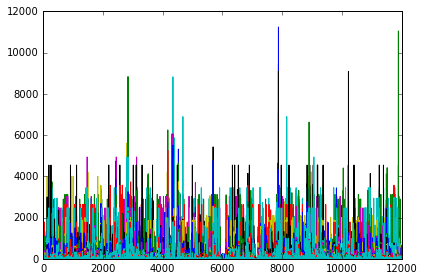

In [4]:
plt.figure()
plt.plot(gene_expression.T);

Clearly it needs to be normalized.  The logarithm is a good way, but we need to do something about those pesky zeros.  So, let's just add one: $\log( \rm{gene} + 1)$

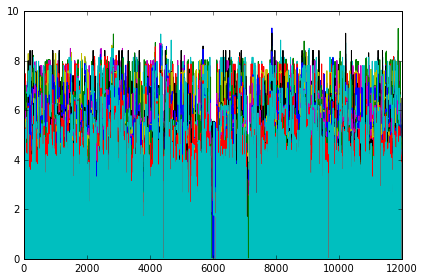

In [6]:
log_expression = np.log(gene_expression + 1)
plt.figure()
plt.plot(log_expression.T);

Just for fun, let's have a look at the histogram of the log-expression for individual genes.

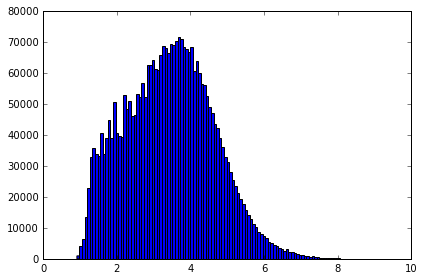

In [13]:
x = log_expression.reshape([-1])
plt.figure()
plt.hist(x[x>0],120);

In [14]:
log_expression /= np.max(log_expression)
vis_data = bh_sne(log_expression.T)

(-40.0, 30.0, -20.0, 25.0)

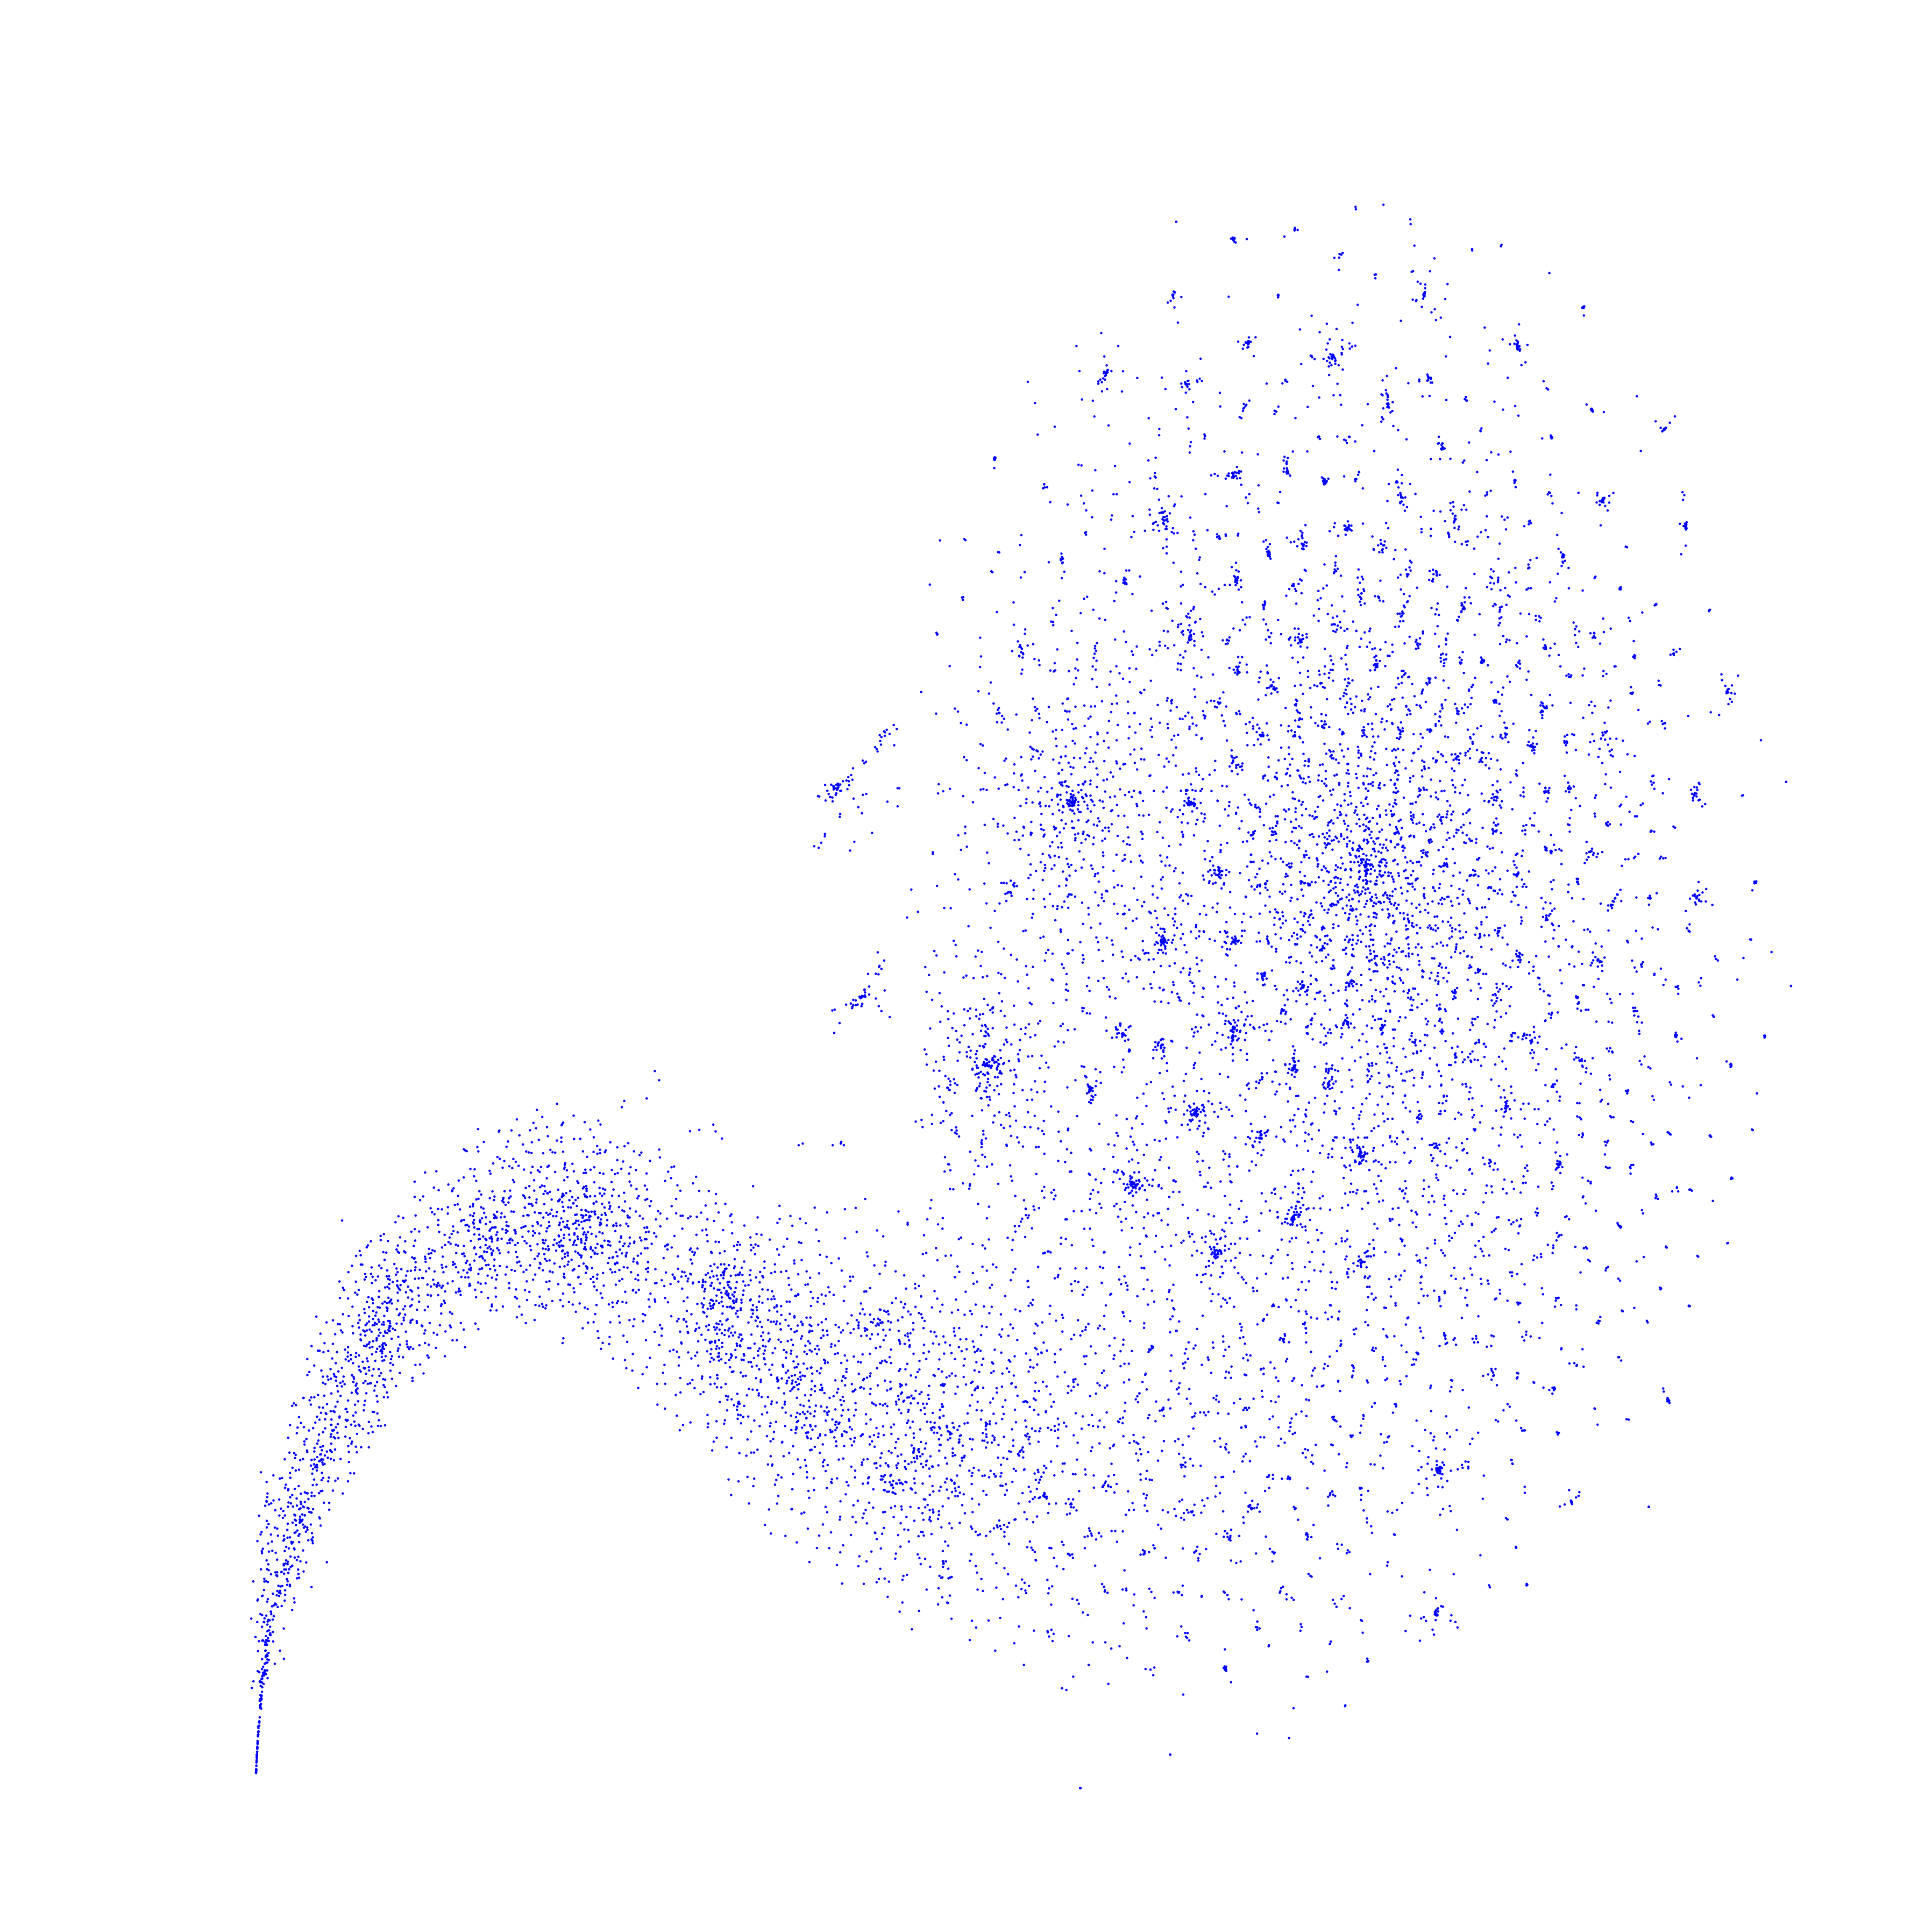

In [32]:
vis_x = vis_data[:,0]
vis_y = vis_data[:,1]
plt.figure(figsize = (10,10))
fig = plt.gcf()
fig.set_size_inches(50, 50, forward=True)
plt.scatter(vis_x, vis_y,edgecolor = 'none')
plt.axis('off');
#plt.savefig('categorical_tSNE_raw.eps', format='eps', dpi=1000)

Cool! The pattern is striking, but it doesn't seem to help our cause.  There are quite a few clusters in the top right, but the twisted funnel shape is beyond me.  This is likely due to the high number of zero expression in single cell RNA-seq data. This helps us realize that simple classification tasks will likely do very poorly when dealing with single-cell RNA-seq gene expression data, which is not a big surprise -- I guess.  That's fine.  We just have to do some preproscessing before we try again, as we expected already. 



## PCA

The 1st pre-processing we can try is PCA.  We can try to project the data onto a small number of principal components, which we will determine by their variance levels.  In doing so, we can reduce not only the number of dimensions, but also the high-frequency noise which can obfuscate our (hopeful) clusters. 

1st generate covariance matrix of log-expression

In [33]:
cov_mat = np.cov(log_expression.T)

Let's visualize the covariance matrix

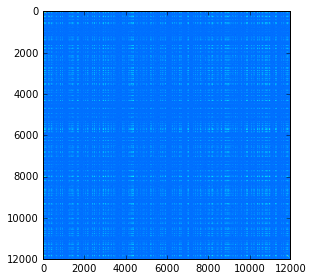

In [34]:
plt.figure()
plt.imshow(cov_mat)

It looks like there are lots of off diagonal terms. This is likely due to the prevalence of zeros in single cell gene expression.  So, it's a little difficult to interpret.

The next step is to calculate the eigenvalues and eigenvectors of our covariance matrix.

In [45]:
from sklearn.decomposition import PCA
pca = PCA(n_components=100)
X_r = pca.fit(log_expression.T).transform(log_expression.T)

In [46]:
np.sum(pca.explained_variance_ratio_)

0.67752941911630615

In [47]:
vis_data = bh_sne(X_r)

(-40.0, 40.0, -40.0, 50.0)

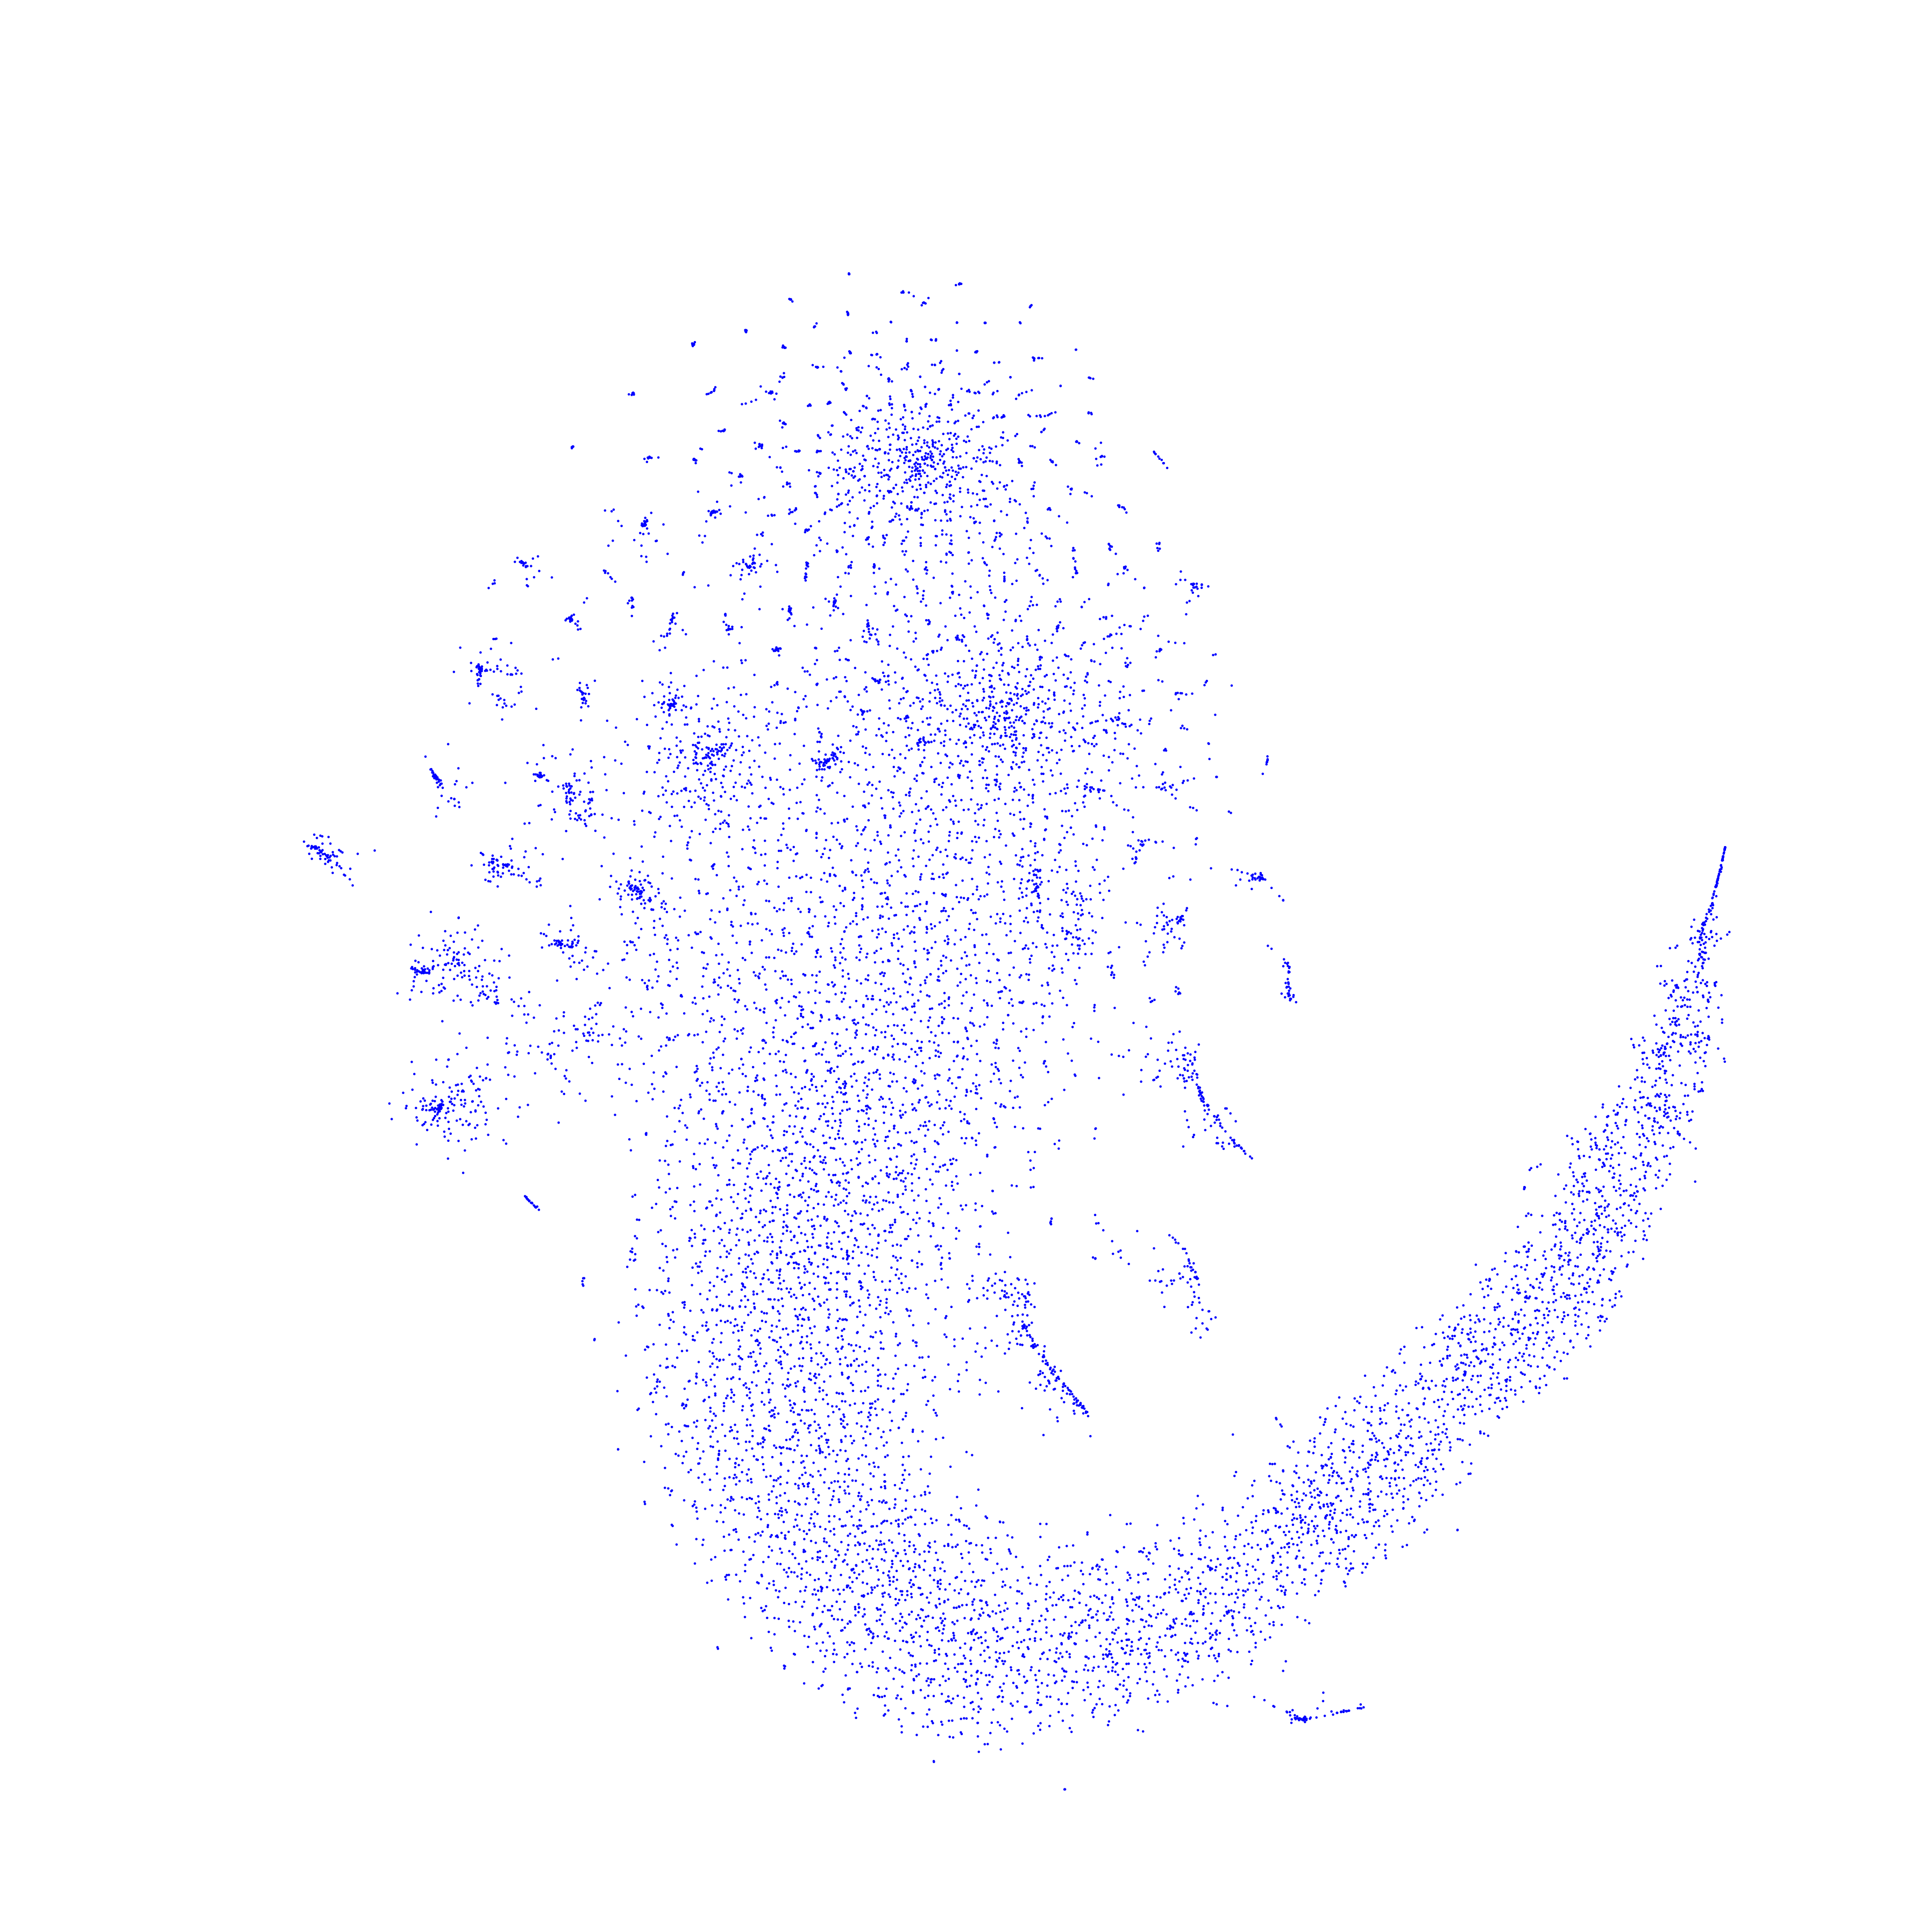

In [48]:
vis_x = vis_data[:,0]
vis_y = vis_data[:,1]
plt.figure(figsize = (10,10))
fig = plt.gcf()
fig.set_size_inches(50, 50, forward=True)
plt.scatter(vis_x, vis_y,edgecolor = 'none')
plt.axis('off');
#plt.savefig('categorical_tSNE_raw.eps', format='eps', dpi=1000)

In [84]:
pca = PCA(n_components=2)
X_r = pca.fit(log_expression.T).transform(log_expression.T)
np.sum(pca.explained_variance_ratio_)

0.59729453622087647

(-80.0, 80.0, -80.0, 60.0)

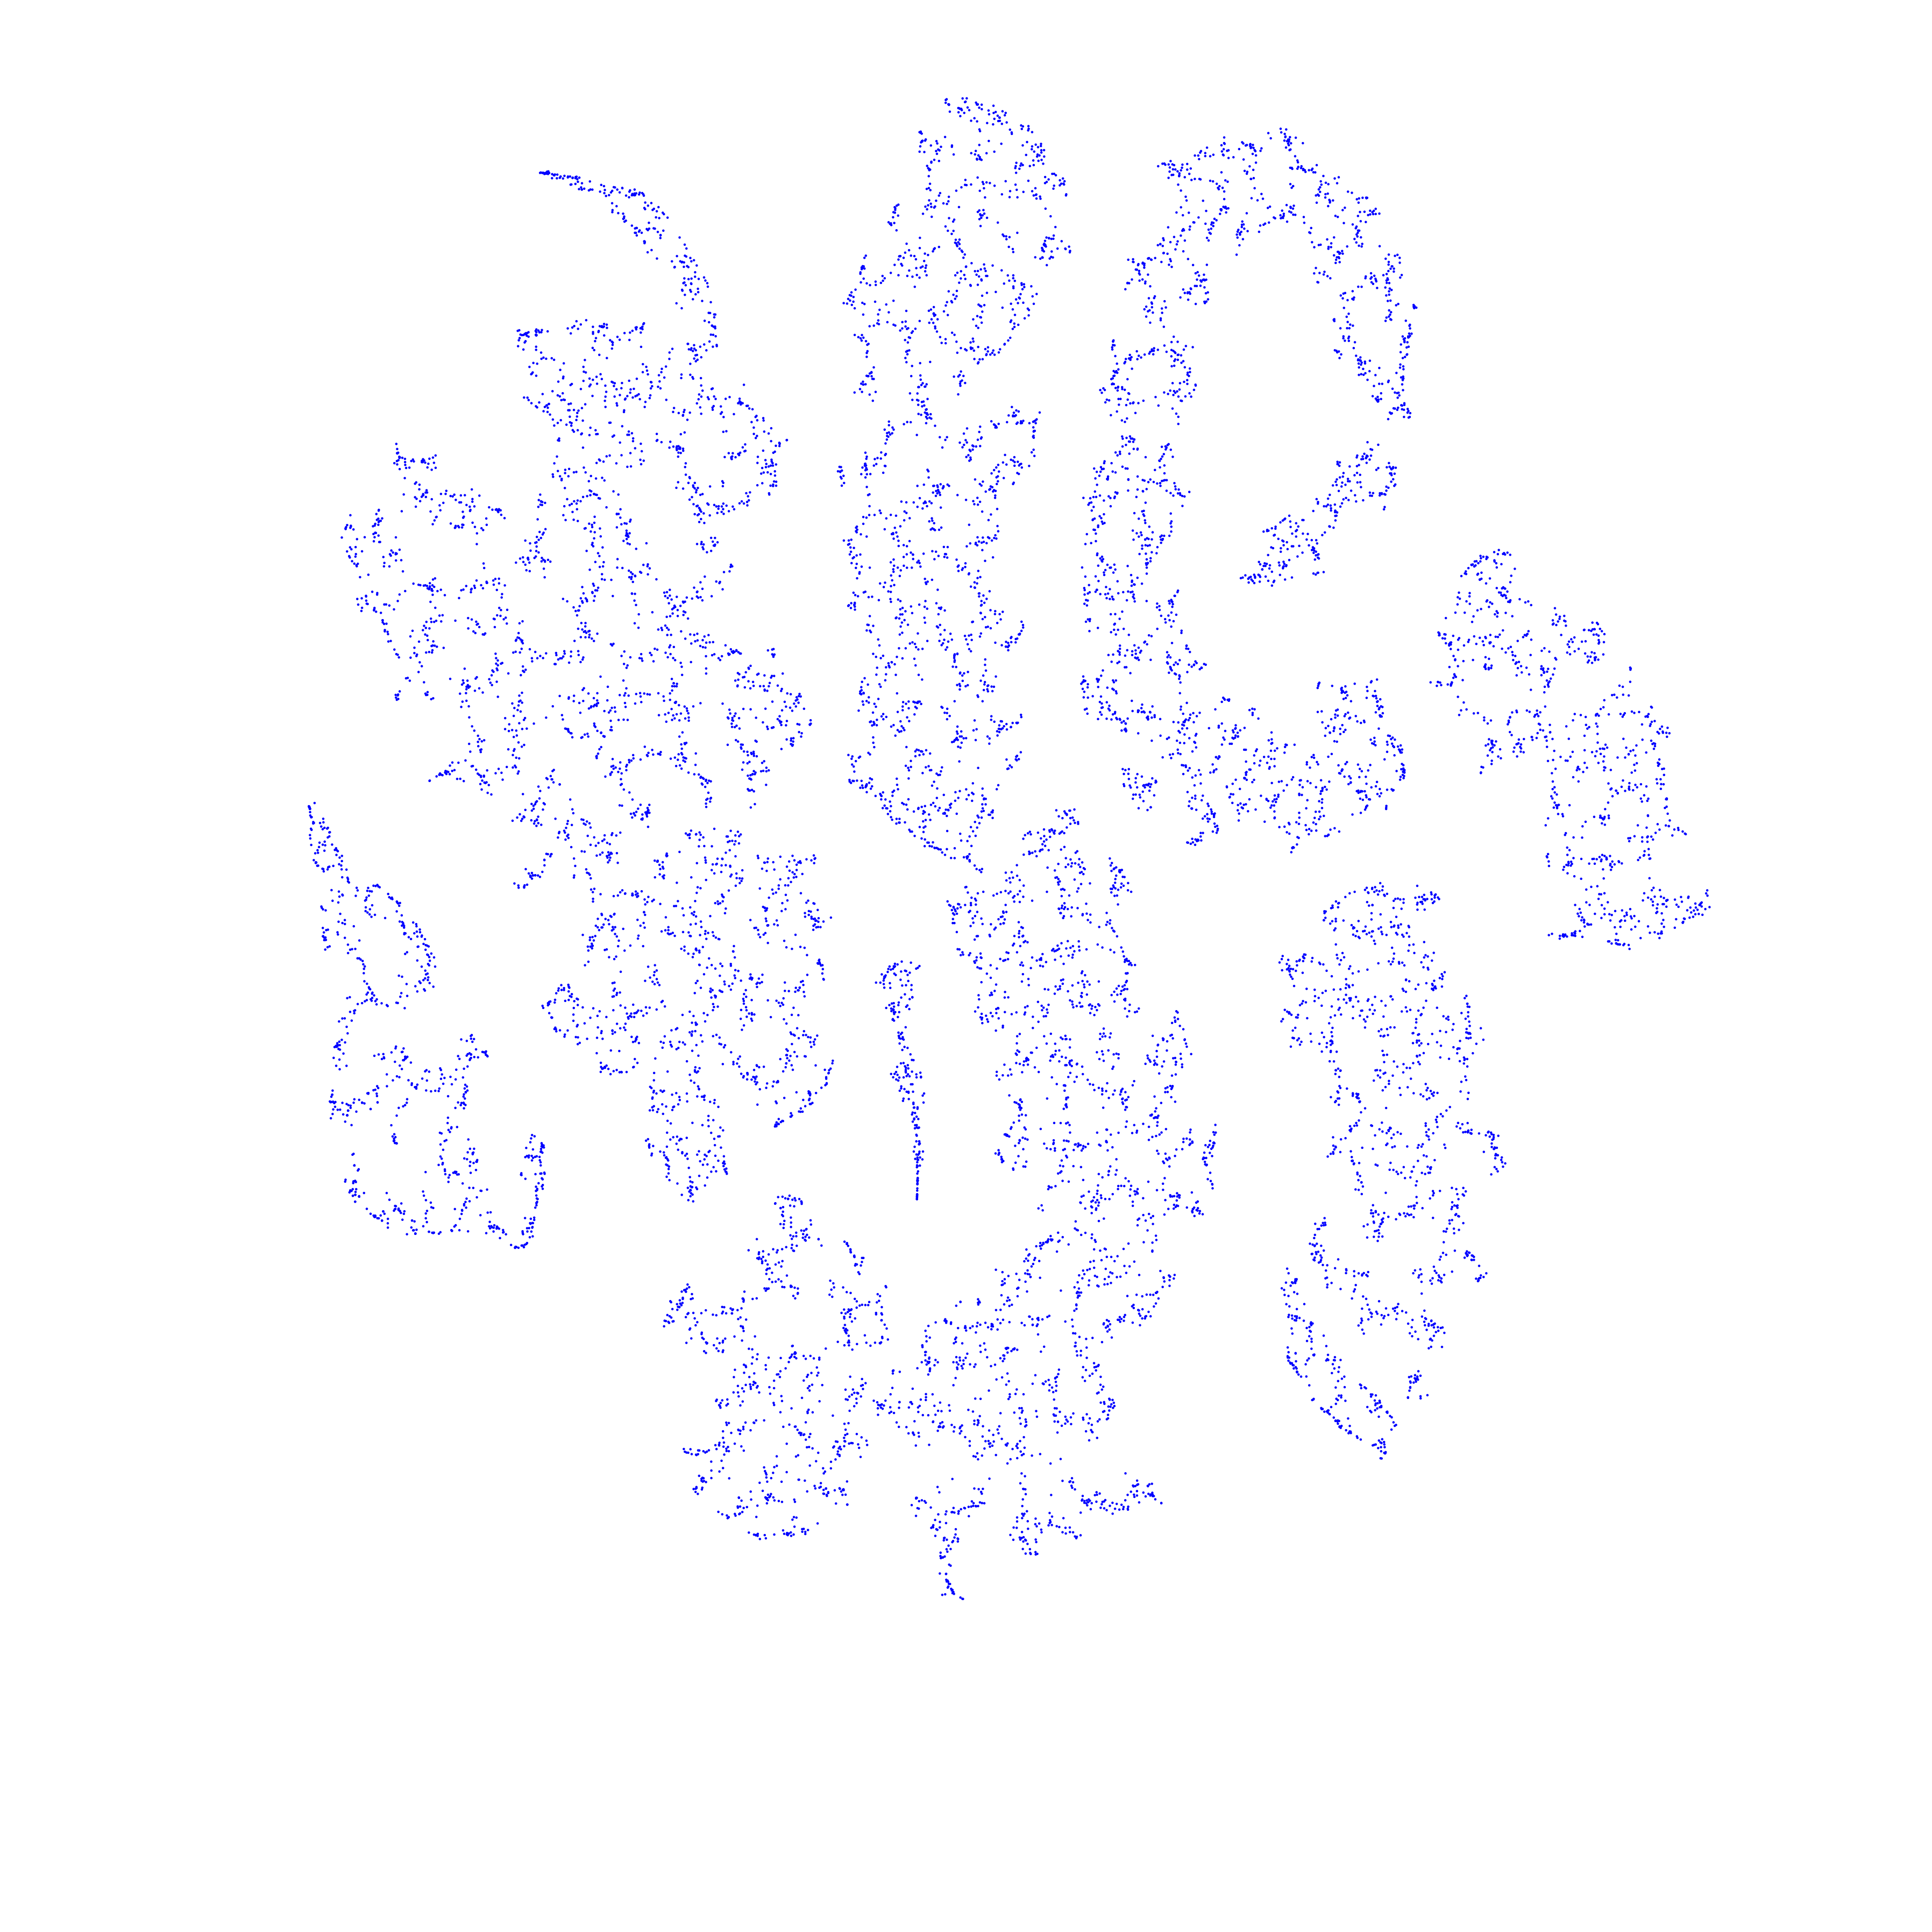

In [85]:
vis_data = bh_sne(X_r)
vis_x = vis_data[:,0]
vis_y = vis_data[:,1]
plt.figure(figsize = (10,10))
fig = plt.gcf()
fig.set_size_inches(50, 50, forward=True)
plt.scatter(vis_x, vis_y,edgecolor = 'none')
plt.axis('off');
#plt.savefig('categorical_tSNE_raw.eps', format='eps', dpi=1000)

## Variational autoencoders

In [144]:
from lasagne import layers, nonlinearities, updates, objectives, init 
from lasagne.layers import get_output, get_output_shape, get_all_params
from lasagne.layers import batch_norm
from lasagne.objectives import aggregate

import theano.tensor as T
import theano
from theano.tensor.shared_randomstreams import RandomStreams

Build the variational autoencoder model

In [157]:
num_encode=2
num_units1=1000
num_units2 = 500


class VariationalSampleLayer(layers.MergeLayer):
    def __init__(self, incoming_mu, incoming_logsigma, **kwargs):
        super(VariationalSampleLayer, self).__init__(incomings=[incoming_mu, incoming_logsigma], **kwargs)
        self.srng = RandomStreams(seed=234)

    def get_output_shape_for(self, input_shapes):
        return input_shapes[0]

    def get_output_for(self, inputs, deterministic=False, **kwargs):
        mu, logsigma = inputs
        shape=(self.input_shapes[0][0] or inputs[0].shape[0],
                self.input_shapes[0][1] or inputs[0].shape[1])
        if deterministic:
            return mu
        return mu + T.exp(logsigma) * self.srng.normal(shape, avg=0.0, std=1).astype(theano.config.floatX)
    
    
input_var = T.dmatrix('inputs')
shape = (None, num_genes)
net = {}
net['input'] = layers.InputLayer(shape=shape, input_var=input_var)
net['encode1'] = batch_norm(layers.DenseLayer(net['input'], num_units=num_units1, W=init.GlorotUniform(), 
                                  b=init.Constant(.0), nonlinearity=nonlinearities.softplus))
net['encode2'] = batch_norm(layers.DenseLayer(net['encode1'], num_units=num_units2, W=init.GlorotUniform(), 
                                  b=init.Constant(.0), nonlinearity=nonlinearities.softplus))
net['encode_mu'] = layers.DenseLayer(net['encode2'], num_units=num_encode, W=init.GlorotUniform(), 
                                  b=init.Constant(.0), nonlinearity=nonlinearities.linear)
net['encode_logsigma'] = layers.DenseLayer(net['encode2'], num_units=num_encode, W=init.GlorotUniform(), 
                                  b=init.Constant(.0), nonlinearity=nonlinearities.linear)
net['Z'] = VariationalSampleLayer(net['encode_mu'], net['encode_logsigma'])

net['decode1'] = batch_norm(layers.DenseLayer(net['Z'], num_units=num_units2, W=init.GlorotUniform(), 
                                  b=init.Constant(.0), nonlinearity=nonlinearities.softplus))
net['decode2'] = batch_norm(layers.DenseLayer(net['decode1'], num_units=num_units1, W=init.GlorotUniform(), 
                                  b=init.Constant(.0), nonlinearity=nonlinearities.softplus))
net['X'] = layers.DenseLayer(net['decode2'], num_units=num_genes,  W=init.GlorotUniform(), 
                                  b=init.Constant(.0), nonlinearity=nonlinearities.sigmoid)
#net['decode_logsigma'] = layers.DenseLayer(net['decode2'], num_units=x_dim, nonlinearity=nonlinearities.linear)
#net['X'] = VariationalSampleLayer(net['decode_mu'], net['decode_logsigma'])

In [158]:
def build_loss(net, target_var, deterministic):
    z_mu = get_output(net['encode_mu'], deterministic=deterministic)
    z_logsigma = T.abs_(get_output(net['encode_logsigma'], deterministic=deterministic))
    x_mu = get_output(net['X'], deterministic=deterministic)
    x_mu = T.clip(T.abs_(x_mu), 1e-7, 1-1e-7)
    x_logsigma = T.log(T.sqrt(x_mu*(1-x_mu)))
    kl_divergence = 0.5*T.sum(1 + 2*z_logsigma - T.sqr(z_mu) - T.exp(2*z_logsigma), axis=1)
    log_likelihood = T.sum(-0.5*T.log(2*np.float32(np.pi))- x_logsigma - 0.5*T.sqr(target_var-x_mu)/T.exp(2*x_logsigma),axis=1)
    variational_lower_bound = -log_likelihood - kl_divergence
    prediction = x_mu
    return variational_lower_bound.mean()


train_loss = build_loss(net, input_var, deterministic=True)

# ADAM updates
params = get_all_params(net['X'], trainable=True)
update_op = updates.adam(train_loss, params, learning_rate=1e-3)
train_fun = theano.function([input_var], train_loss , updates=update_op)

In [159]:
# rescale data to make it from 0 to 1
X_train = log_expression/np.max(log_expression)
X_train.shape

(1152, 11978)

In [167]:
# generates mini-batch samples
def batch_generator(X, batch_size=128, shuffle=True):
    if shuffle:
        indices = np.arange(len(X))
        np.random.shuffle(indices)
    for start_idx in range(0, len(X)-batch_size+1, batch_size):
        if shuffle:
            excerpt = indices[start_idx:start_idx+batch_size]
        else:
            excerpt = slice(start_idx, start_idx+batch_size)
        yield X[excerpt].astype(np.float32)
        
# train the network with mini-batch stochastic gradient descent with ADAM updates
num_epochs = 20
batch_size = 48
num_train_batches = X_train.shape[0] // batch_size
for epoch in range(num_epochs):
    train_batches = batch_generator(X_train, batch_size, shuffle=True)

    train_loss = 0
    for index in range(num_train_batches):
        loss = train_fun(next(train_batches))
        train_loss += loss

    print("Epoch {} of {}".format(epoch+1, num_epochs))
    print("  training loss:\t\t{:.6f}".format(train_loss/num_train_batches))

Epoch 1 of 20
  training loss:		-21601.961234
Epoch 2 of 20
  training loss:		-21649.323555
Epoch 3 of 20
  training loss:		-21757.281771
Epoch 4 of 20
  training loss:		-21860.916656
Epoch 5 of 20
  training loss:		-21963.656060
Epoch 6 of 20
  training loss:		-22030.474561
Epoch 7 of 20
  training loss:		-22135.871026
Epoch 8 of 20
  training loss:		-22208.740288
Epoch 9 of 20
  training loss:		-22259.101824
Epoch 10 of 20
  training loss:		-22324.023638
Epoch 11 of 20
  training loss:		-22361.447650
Epoch 12 of 20
  training loss:		-11454.819743
Epoch 13 of 20
  training loss:		-826.005170
Epoch 14 of 20
  training loss:		-17835.870342
Epoch 15 of 20
  training loss:		-18713.398871
Epoch 16 of 20
  training loss:		-19123.802850
Epoch 17 of 20
  training loss:		-19370.027906
Epoch 18 of 20
  training loss:		-19556.085789
Epoch 19 of 20
  training loss:		-19711.039977
Epoch 20 of 20
  training loss:		-19852.650031


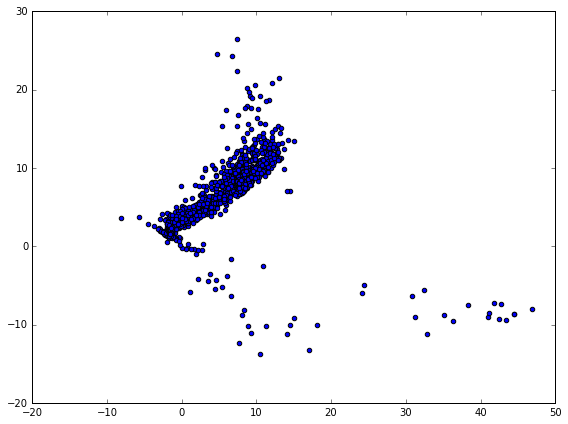

In [168]:
z = get_output(net['Z'], deterministic=True)
test_fun = theano.function([input_var], z)

train_batches = batch_generator(X_train, batch_size, shuffle=True)
prediction = []
for index in range(num_train_batches):
    prediction.append(test_fun(next(train_batches)))
    
prediction = np.array(prediction).reshape([-1,2])
plt.figure(figsize=(8, 6)) 
plt.scatter(prediction[:,0], prediction[:,1])
#plt.savefig('MNIST_vae_class_scatter.eps', format='eps', dpi=1000)

In [188]:
num_encode=25
num_units1=500
num_units2 = 250

input_var = T.dmatrix('inputs')
shape = (None, num_genes)
net = {}
net['input'] = layers.InputLayer(shape=shape, input_var=input_var)
net['encode1'] = batch_norm(layers.DenseLayer(net['input'], num_units=num_units1, W=init.GlorotUniform(), 
                                  b=init.Constant(.0), nonlinearity=nonlinearities.softplus))
net['encode2'] = batch_norm(layers.DenseLayer(net['encode1'], num_units=num_units2, W=init.GlorotUniform(), 
                                  b=init.Constant(.0), nonlinearity=nonlinearities.softplus))
net['encode_mu'] = layers.DenseLayer(net['encode2'], num_units=num_encode, W=init.GlorotUniform(), 
                                  b=init.Constant(.0), nonlinearity=nonlinearities.linear)
net['encode_logsigma'] = layers.DenseLayer(net['encode2'], num_units=num_encode, W=init.GlorotUniform(), 
                                  b=init.Constant(.0), nonlinearity=nonlinearities.linear)
net['Z'] = VariationalSampleLayer(net['encode_mu'], net['encode_logsigma'])

net['decode1'] = batch_norm(layers.DenseLayer(net['Z'], num_units=num_units2, W=init.GlorotUniform(), 
                                  b=init.Constant(.0), nonlinearity=nonlinearities.softplus))
net['decode2'] = batch_norm(layers.DenseLayer(net['decode1'], num_units=num_units1, W=init.GlorotUniform(), 
                                  b=init.Constant(.0), nonlinearity=nonlinearities.softplus))
net['X'] = layers.DenseLayer(net['decode2'], num_units=num_genes,  W=init.GlorotUniform(), 
                                  b=init.Constant(.0), nonlinearity=nonlinearities.sigmoid)


def build_loss(net, target_var, deterministic):
    z_mu = get_output(net['encode_mu'], deterministic=deterministic)
    z_logsigma = T.abs_(get_output(net['encode_logsigma'], deterministic=deterministic))
    x_mu = get_output(net['X'], deterministic=deterministic)
    x_mu = T.clip(T.abs_(x_mu), 1e-7, 1-1e-7)
    x_logsigma = T.log(T.sqrt(x_mu*(1-x_mu)))
    kl_divergence = 0.5*T.sum(1 + 2*z_logsigma - T.sqr(z_mu) - T.exp(2*z_logsigma), axis=1)
    log_likelihood = T.sum(-0.5*T.log(2*np.float32(np.pi))- x_logsigma - 0.5*T.sqr(target_var-x_mu)/T.exp(2*x_logsigma),axis=1)
    variational_lower_bound = -log_likelihood - kl_divergence
    prediction = x_mu
    return variational_lower_bound.mean()


train_loss = build_loss(net, input_var, deterministic=True)

# ADAM updates
params = get_all_params(net['X'], trainable=True)
update_op = updates.adam(train_loss, params, learning_rate=1e-3)
train_fun = theano.function([input_var], train_loss , updates=update_op)

In [190]:
# generates mini-batch samples
def batch_generator(X, batch_size=128, shuffle=True):
    if shuffle:
        indices = np.arange(len(X))
        np.random.shuffle(indices)
    for start_idx in range(0, len(X)-batch_size+1, batch_size):
        if shuffle:
            excerpt = indices[start_idx:start_idx+batch_size]
        else:
            excerpt = slice(start_idx, start_idx+batch_size)
        yield X[excerpt].astype(np.float32)
        
# train the network with mini-batch stochastic gradient descent with ADAM updates
num_epochs = 50
batch_size = 48
num_train_batches = X_train.shape[0] // batch_size
for epoch in range(num_epochs):
    train_batches = batch_generator(X_train, batch_size, shuffle=True)

    train_loss = 0
    for index in range(num_train_batches):
        loss = train_fun(next(train_batches))
        train_loss += loss

    print("Epoch {} of {}".format(epoch+1, num_epochs))
    print("  training loss:\t\t{:.6f}".format(train_loss/num_train_batches))

Epoch 1 of 50
  training loss:		-21484.939766
Epoch 2 of 50
  training loss:		-21699.142489
Epoch 3 of 50
  training loss:		-21857.227520
Epoch 4 of 50
  training loss:		-21987.448570
Epoch 5 of 50
  training loss:		-21982.385120
Epoch 6 of 50
  training loss:		-21970.575016
Epoch 7 of 50
  training loss:		-22217.098433
Epoch 8 of 50
  training loss:		-22451.416060
Epoch 9 of 50
  training loss:		-22584.481517
Epoch 10 of 50
  training loss:		-22706.025038
Epoch 11 of 50
  training loss:		-22885.958188
Epoch 12 of 50
  training loss:		-22958.935456
Epoch 13 of 50
  training loss:		-22963.945676
Epoch 14 of 50
  training loss:		-23221.593443
Epoch 15 of 50
  training loss:		-23388.478430
Epoch 16 of 50
  training loss:		-23508.963442
Epoch 17 of 50
  training loss:		-23656.278276
Epoch 18 of 50
  training loss:		-23835.945075
Epoch 19 of 50
  training loss:		-23945.001463
Epoch 20 of 50
  training loss:		-24147.119498
Epoch 21 of 50
  training loss:		-18653.317723
Epoch 22 of 50
  train

In [191]:
z_mu = get_output(net['Z'], deterministic=True)
statistics_fun = theano.function([input_var],[z_mu])
stats = statistics_fun(X_train)

In [192]:
stats = np.array(stats)
stats = stats[0]
stats.shape

(1152, 25)

(array([ -5.,   0.,   5.,  10.,  15.,  20.,  25.]),
 <a list of 7 Text xticklabel objects>)

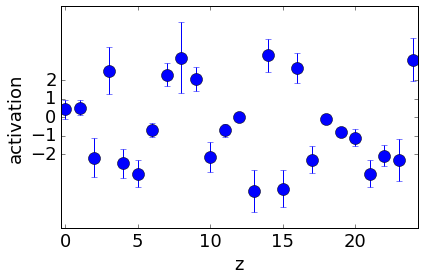

In [193]:
plt.figure
plt.errorbar(range(num_encode),np.mean(stats,axis=0),np.std(stats,axis=0), fmt='o', markersize=12)
plt.xlim([-.3, num_encode-.7])
plt.xlabel('z', fontsize=18)
plt.ylabel('activation', fontsize=18)
plt.yticks([-2, -1, 0, 1, 2], fontsize = 18)
plt.xticks(fontsize = 18)

(-50.0, 30.0, -40.0, 40.0)

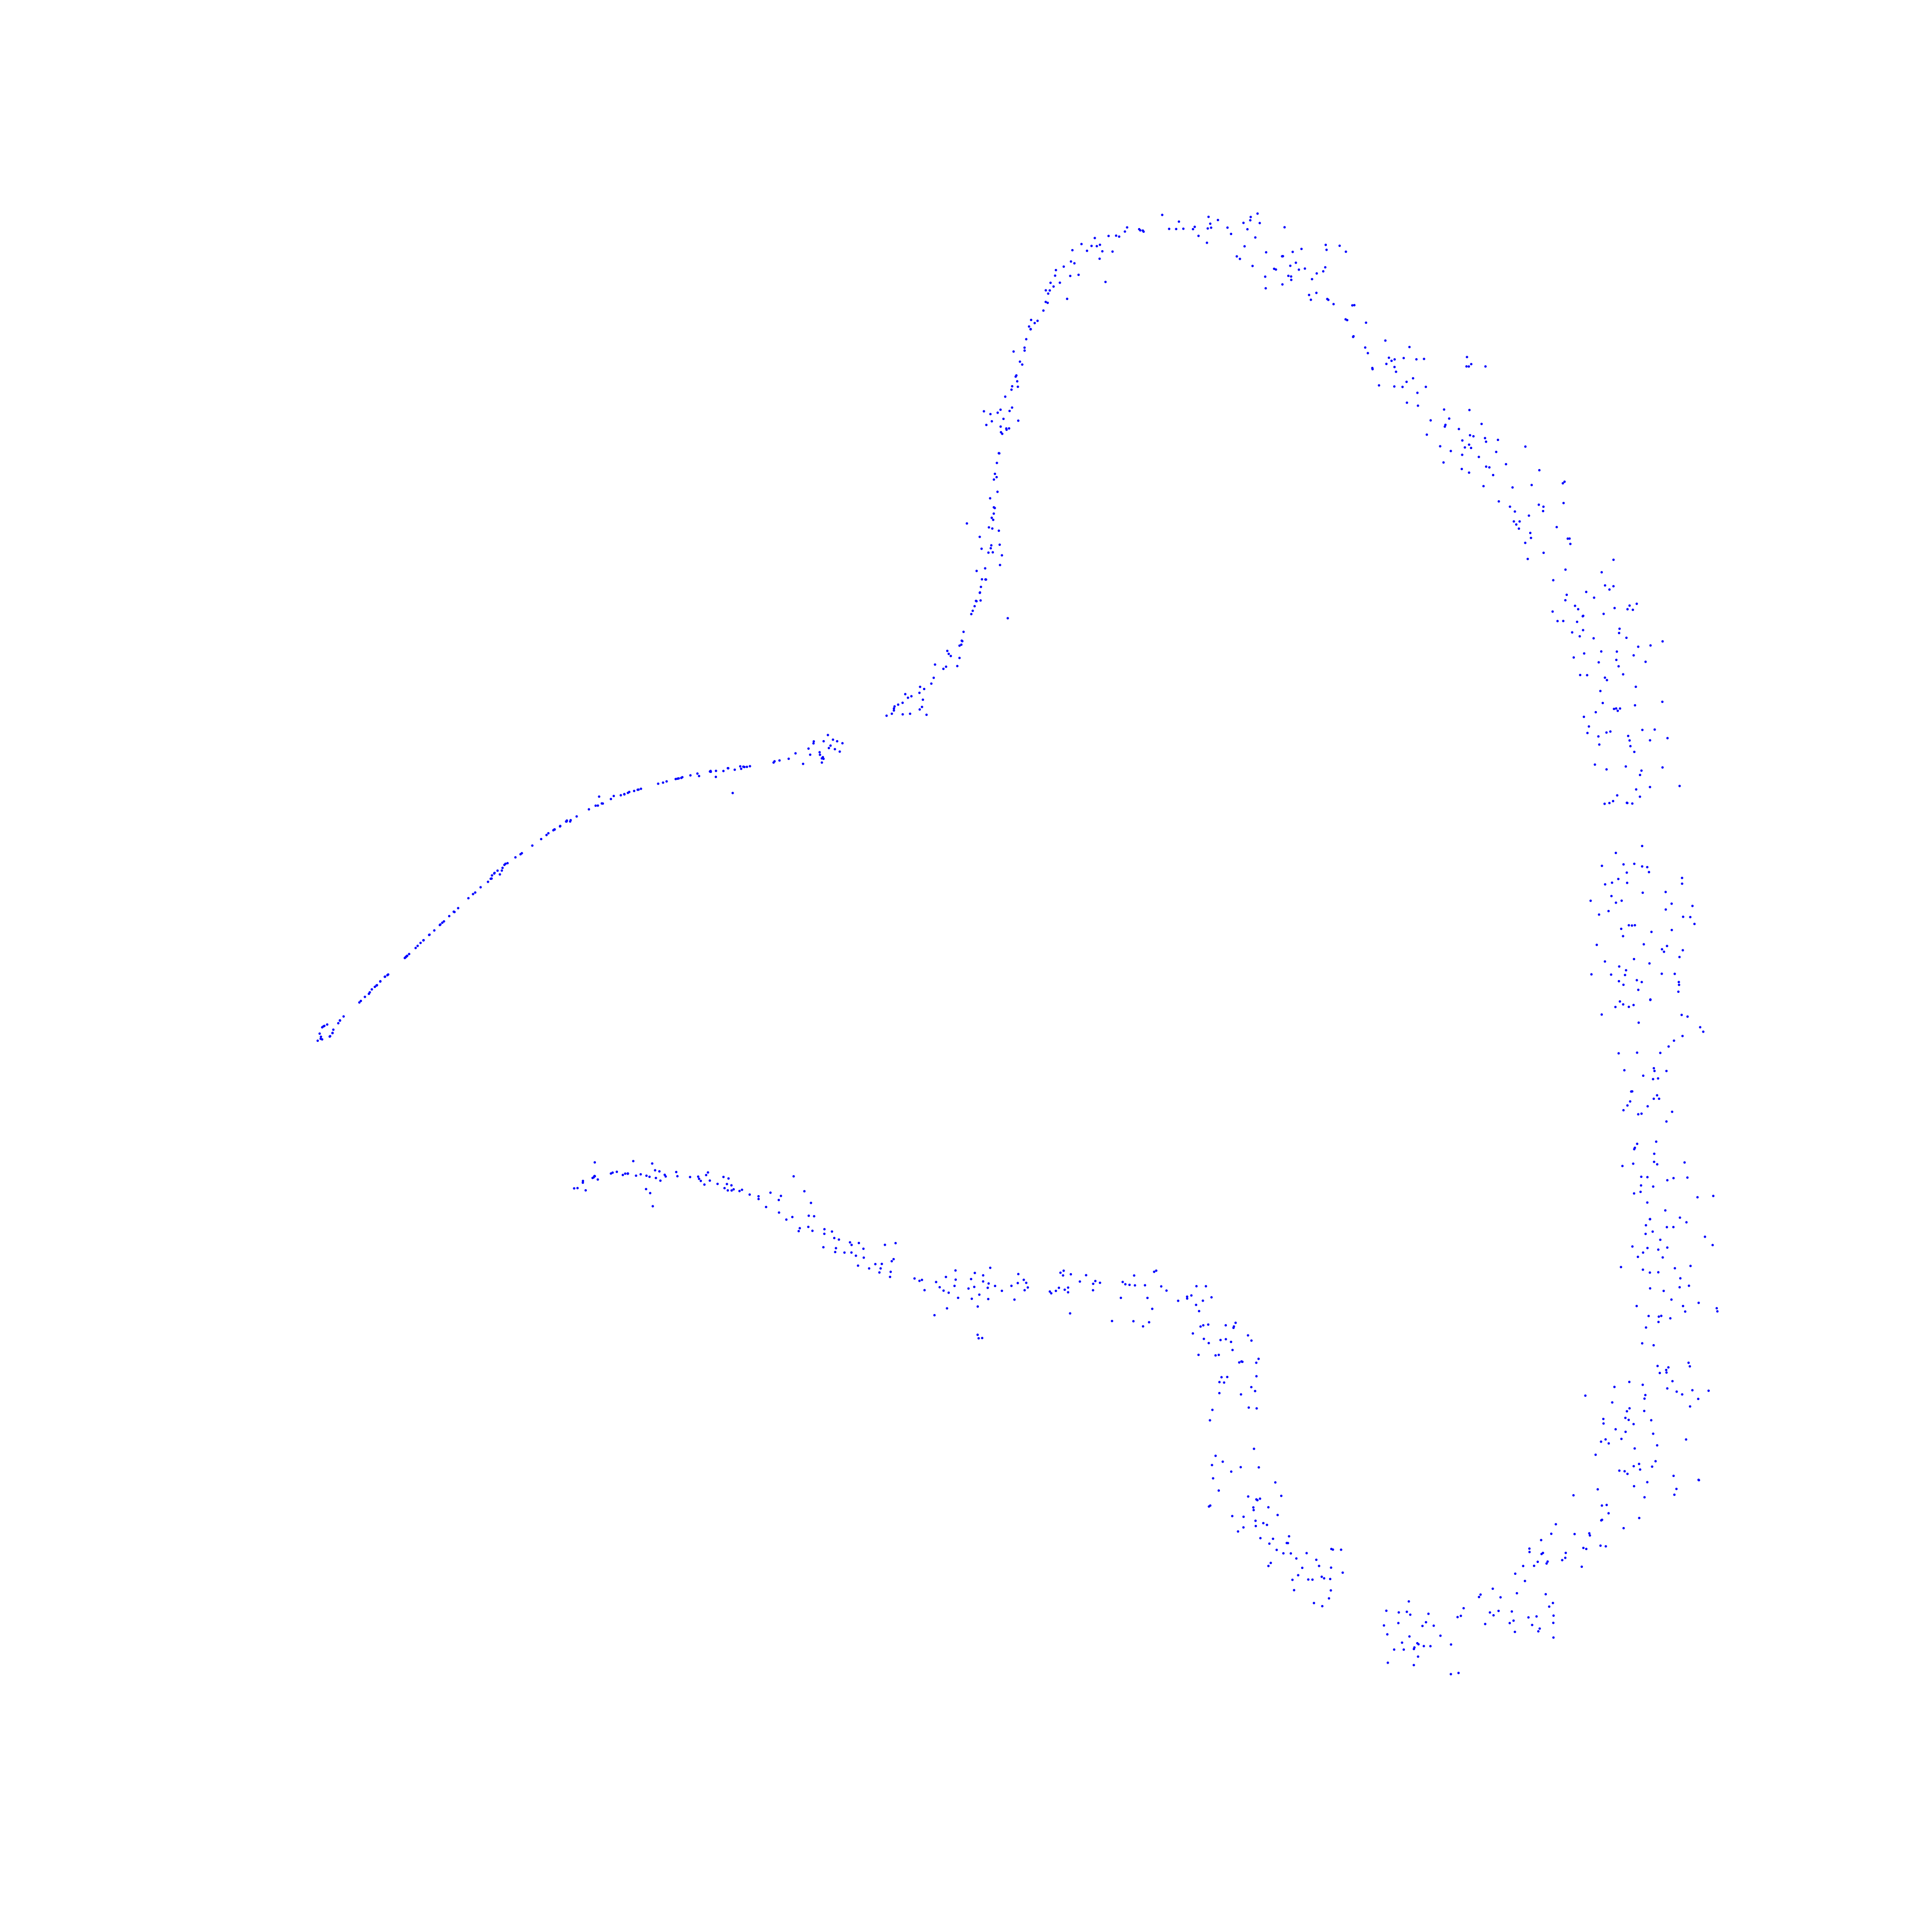

In [176]:
vis_data = bh_sne(stats)
vis_x = vis_data[:,0]
vis_y = vis_data[:,1]
plt.figure(figsize = (10,10))
fig = plt.gcf()
fig.set_size_inches(50, 50, forward=True)
plt.scatter(vis_x, vis_y,edgecolor = 'none')
plt.axis('off');
#plt.savefig('categorical_tSNE_raw.eps', format='eps', dpi=1000)


In [194]:
z = get_output(net['X'], deterministic=True)
test_fun = theano.function([input_var], z)

batch_size = 1
num_train_batches = X_train.shape[0] // batch_size
train_batches = batch_generator(X_train, batch_size, shuffle=True)
prediction = []
for index in range(num_train_batches):
    prediction.append(test_fun(next(train_batches)))
    
prediction = np.array(prediction)
prediction.shape


(1152, 1, 11978)

In [195]:
prediction = np.squeeze(prediction.transpose([0, 2,1]))
prediction.shape

(1152, 11978)

(-80.0, 60.0, -60.0, 60.0)

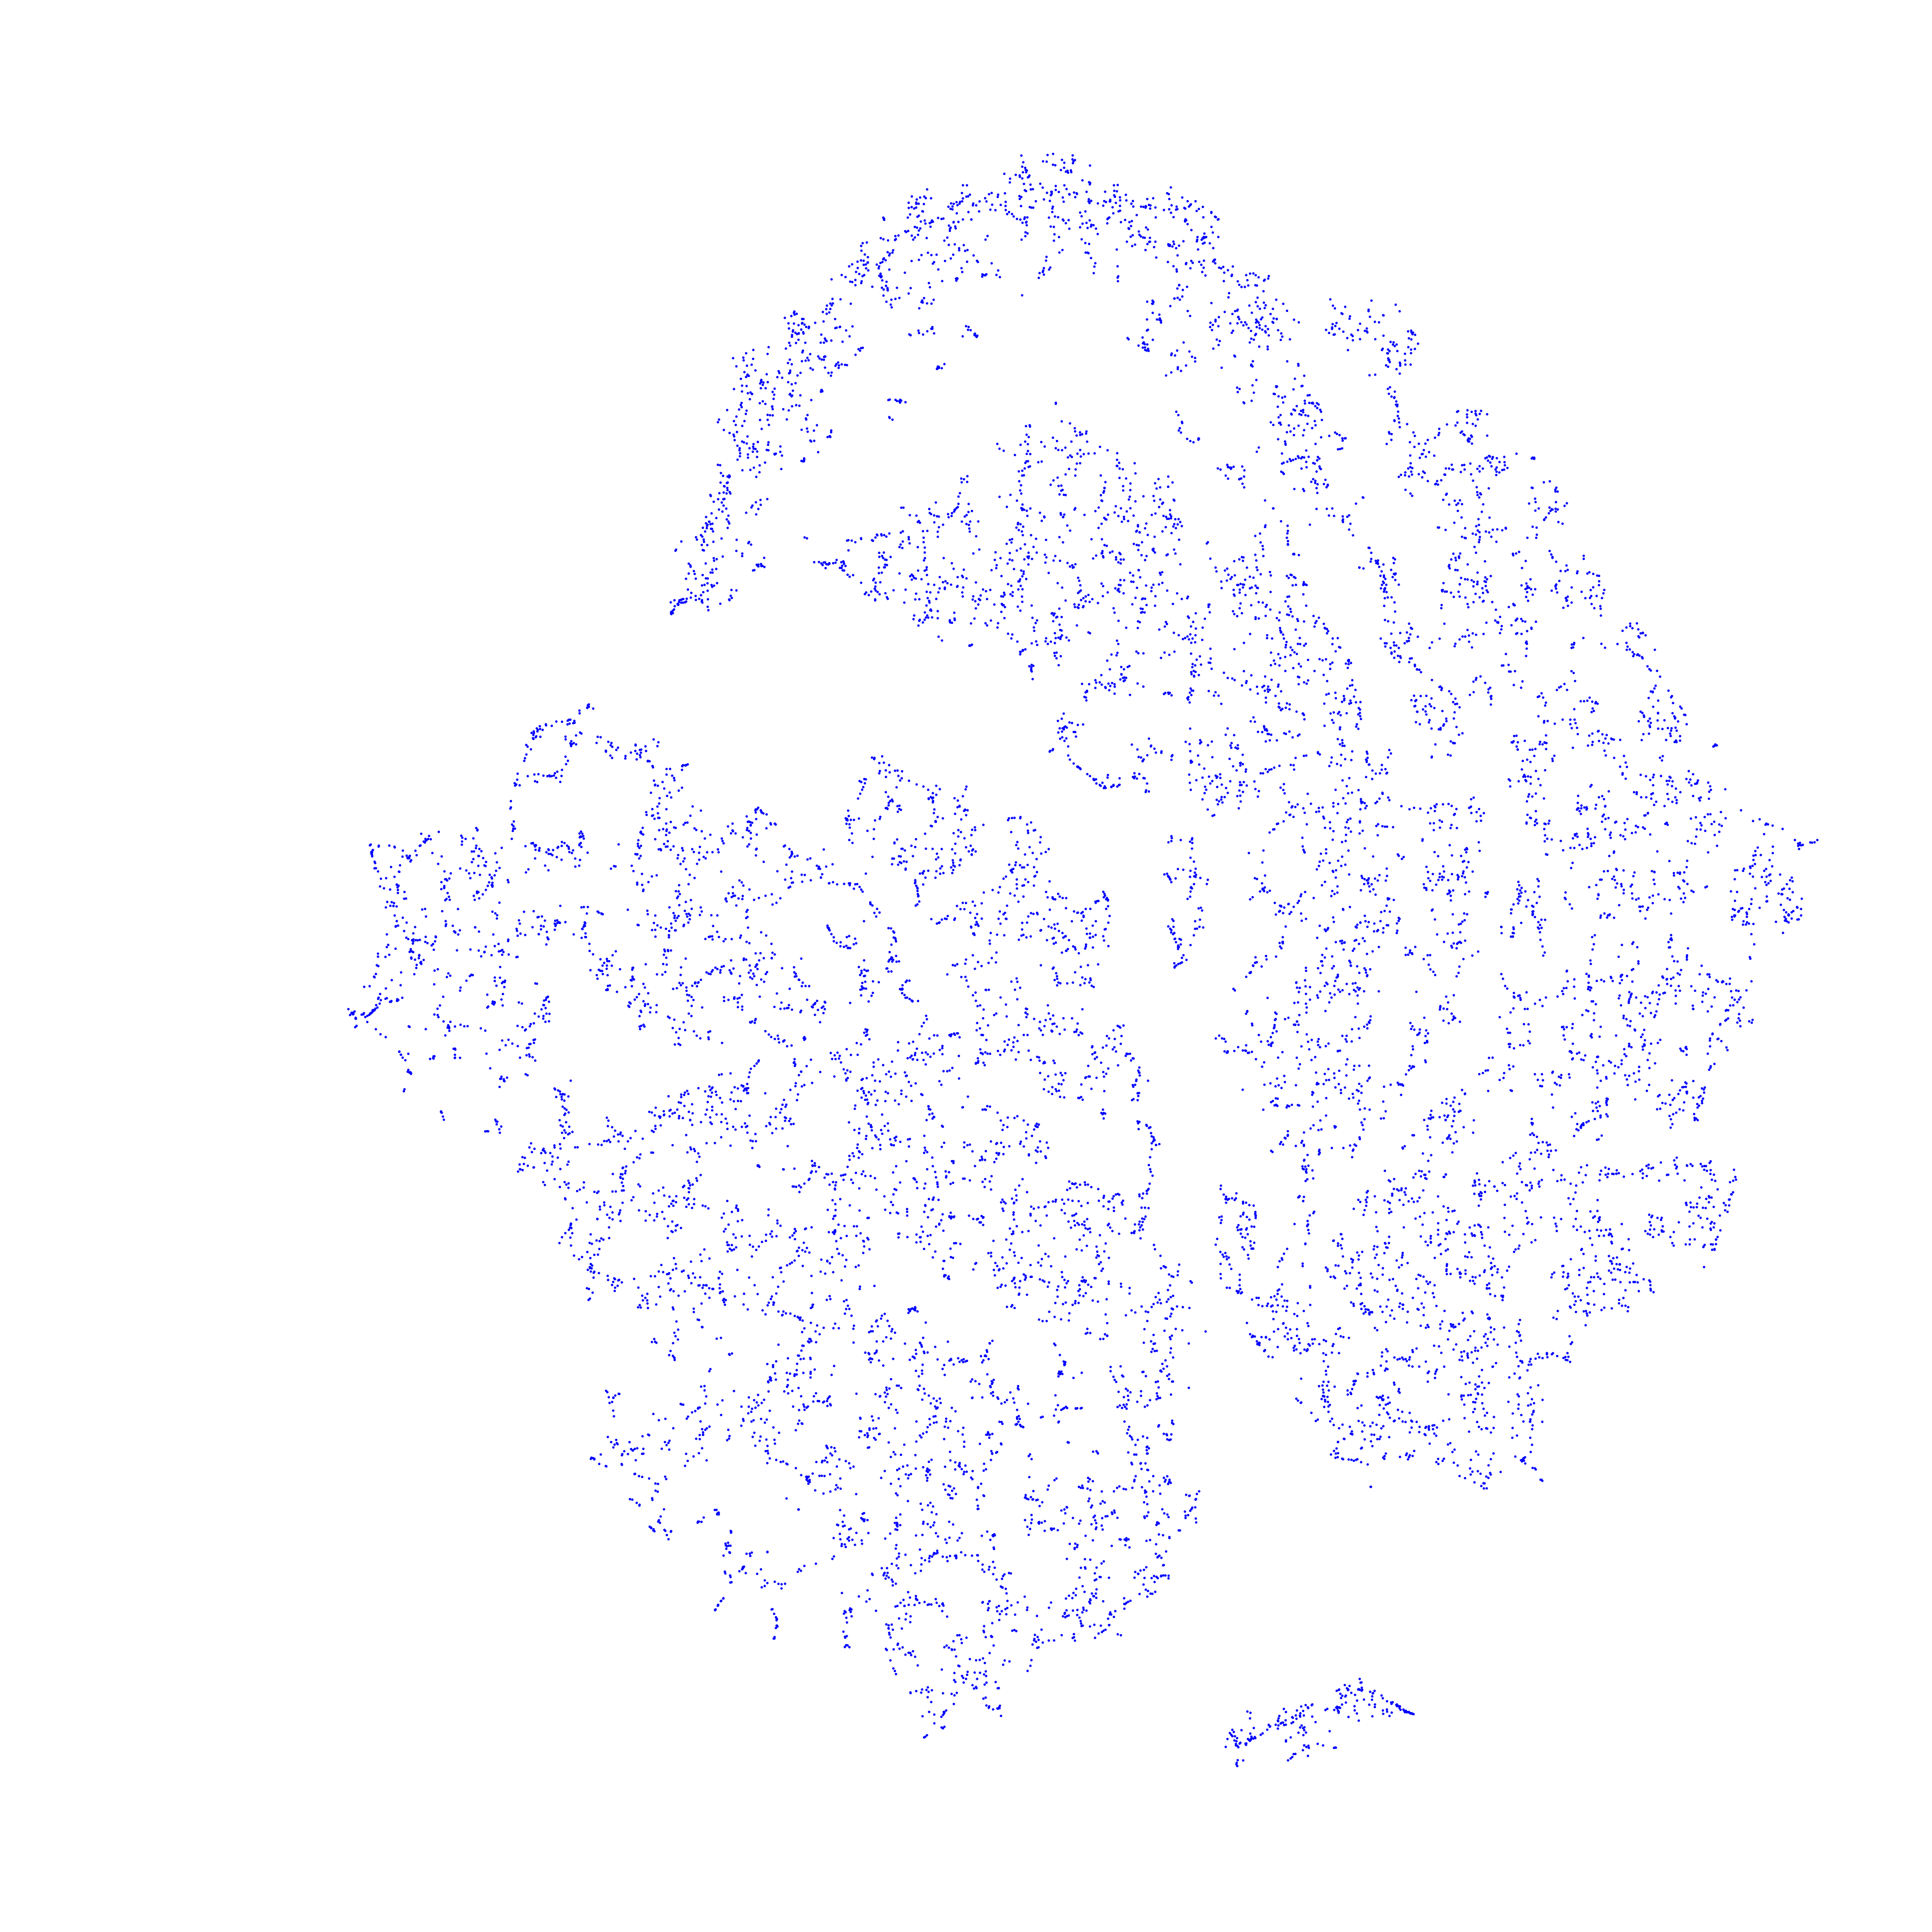

In [196]:
vis_data = bh_sne(prediction.T)
vis_x = vis_data[:,0]
vis_y = vis_data[:,1]
plt.figure(figsize = (10,10))
fig = plt.gcf()
fig.set_size_inches(50, 50, forward=True)
plt.scatter(vis_x, vis_y,edgecolor = 'none')
plt.axis('off');
#plt.savefig('categorical_tSNE_raw.eps', format='eps', dpi=1000)

(1152, 100)

(-60.0, 80.0, -80.0, 60.0)

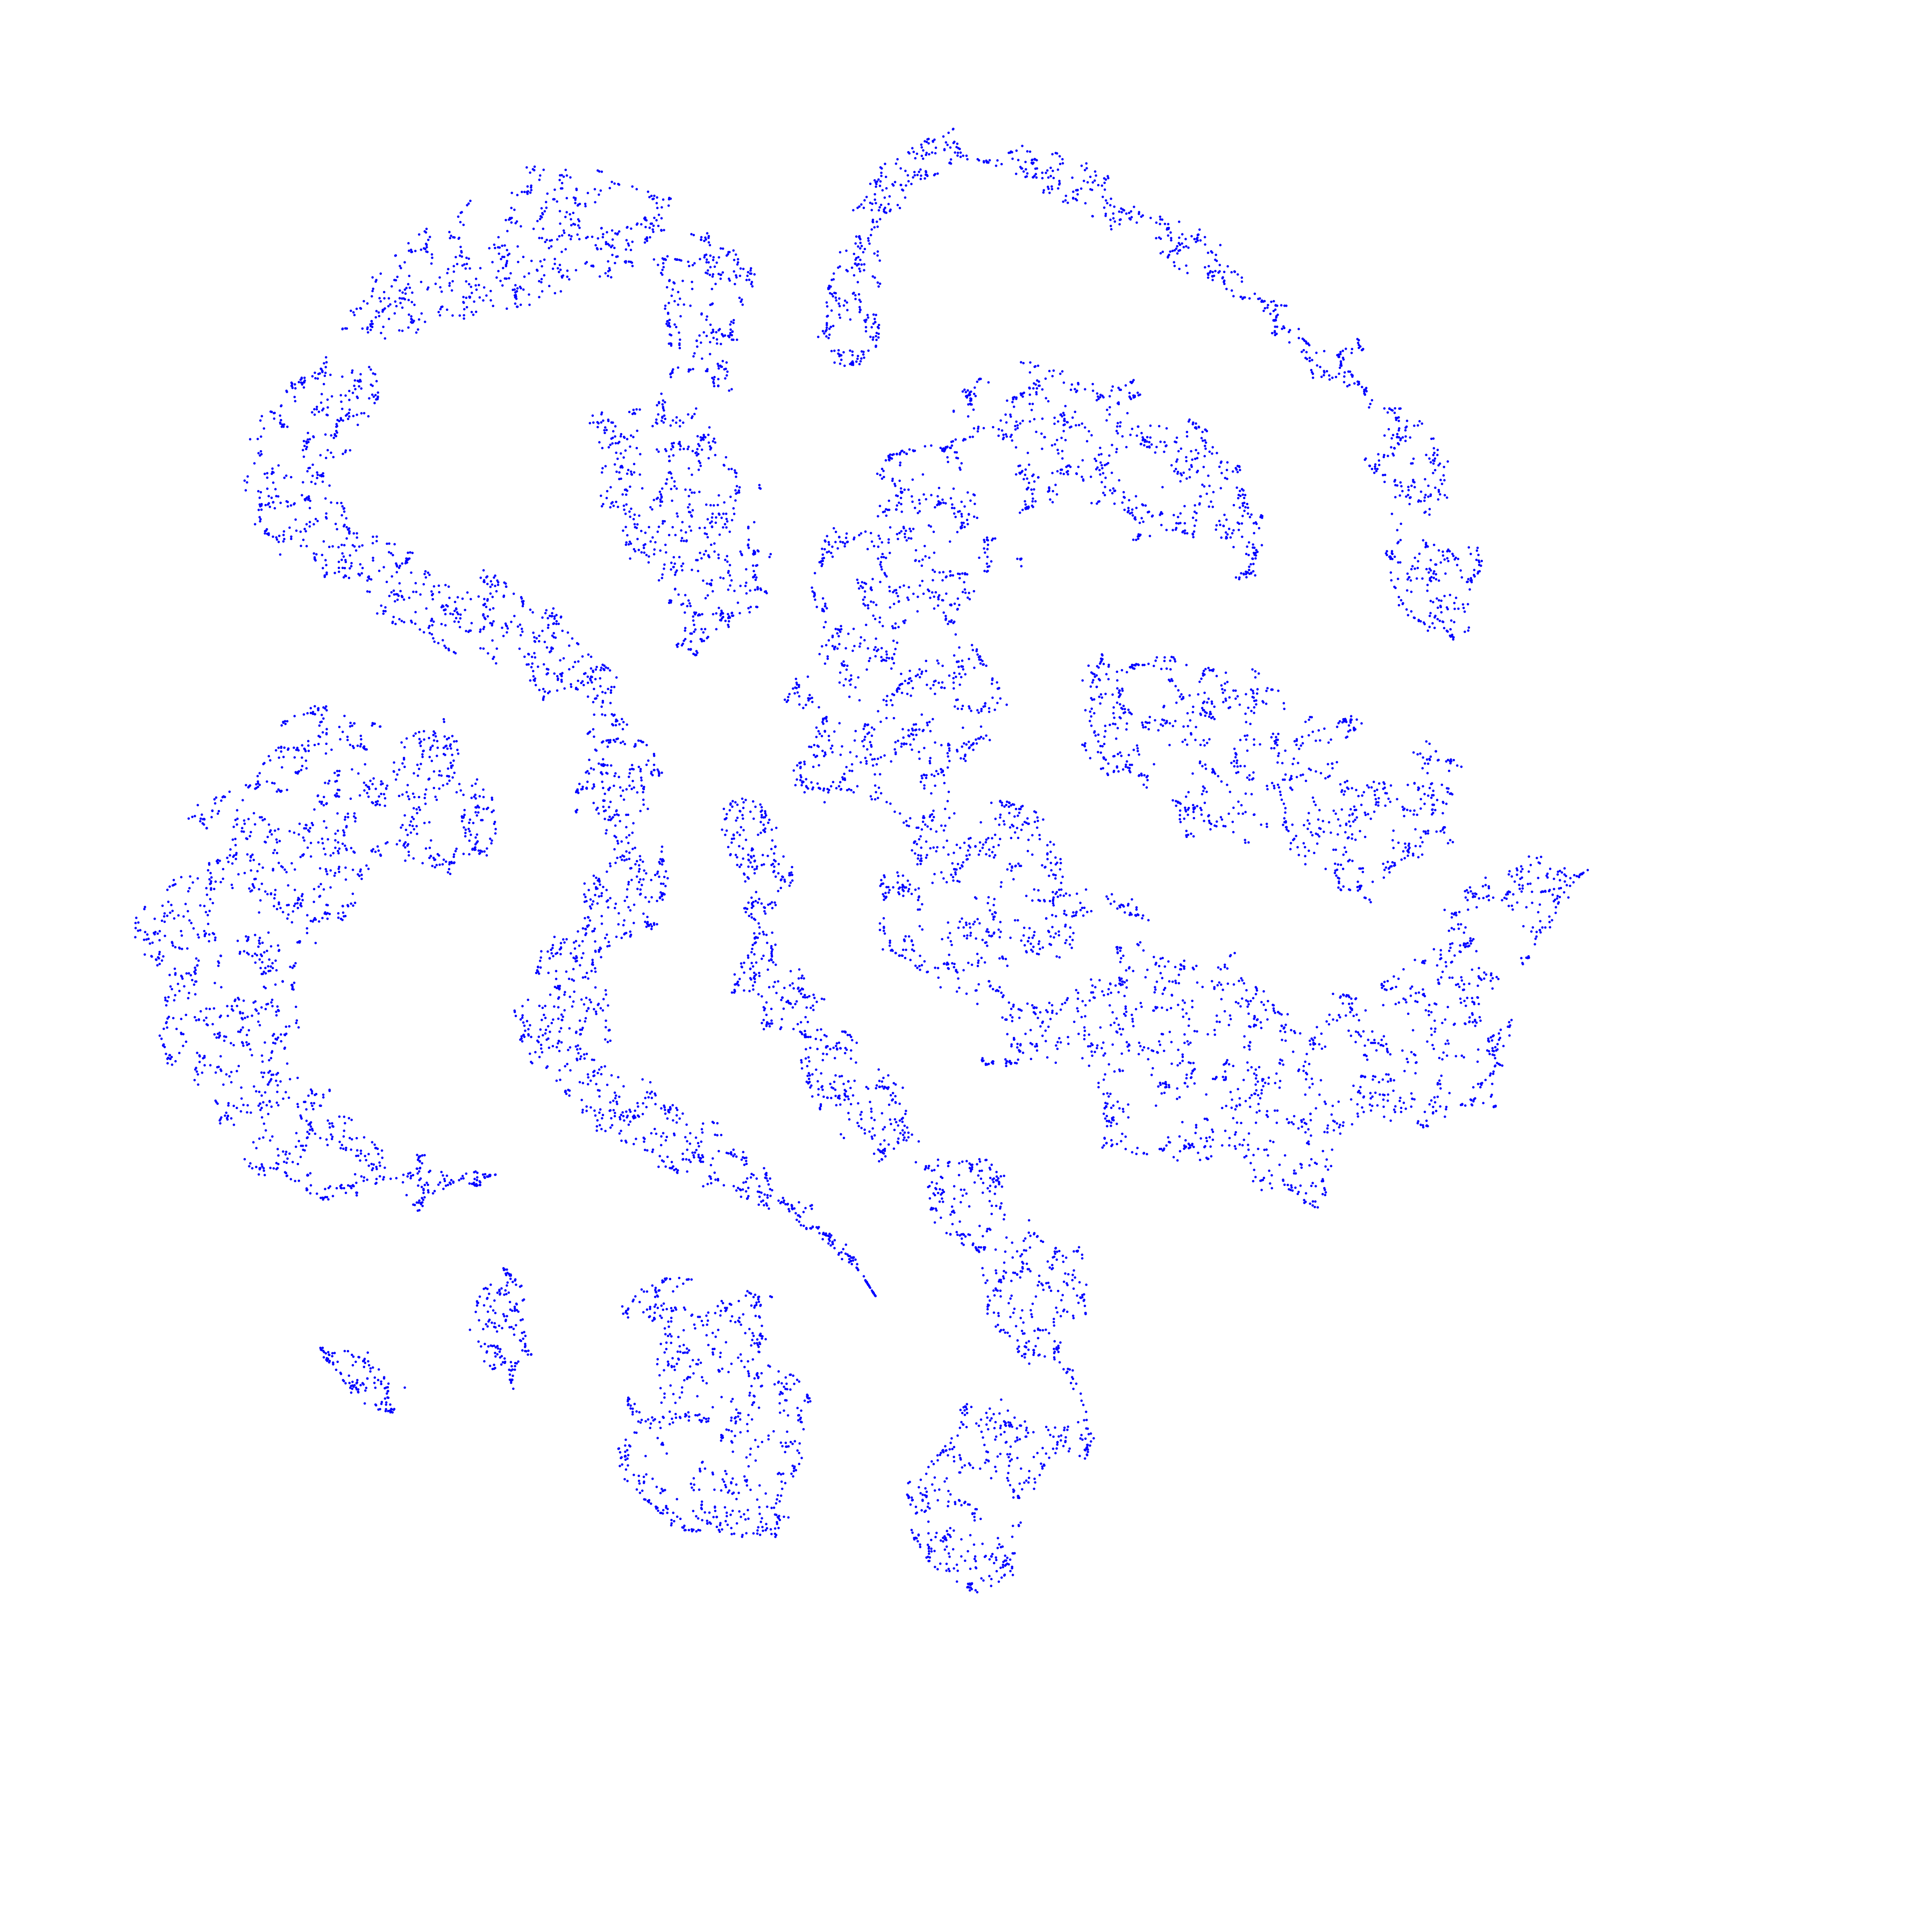

In [37]:
vis_data = bh_sne(prediction.T)
vis_x = vis_data[:,0]
vis_y = vis_data[:,1]
plt.figure(figsize = (10,10))
fig = plt.gcf()
fig.set_size_inches(50, 50, forward=True)
plt.scatter(vis_x, vis_y,edgecolor = 'none')
plt.axis('off');
#plt.savefig('categorical_tSNE_raw.eps', format='eps', dpi=1000)

In [43]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
X_r = pca.fit(prediction.T).transform(prediction.T)
np.sum(pca.explained_variance_ratio_)

0.99999983105636103

(11978, 2)